In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import numpy as np
from variation_utils import calculate_katz
from scipy.sparse.linalg import eigs
import scipy.sparse as sp

def get_edge_vector_from_adj_matrix(adj_matrix):
    sparse_matrix = sp.csr_matrix(adj_matrix)
    row_indices, col_indices = sparse_matrix.nonzero()
    edge_vector = np.vstack((row_indices, col_indices)).T
    return edge_vector

def generate_adjacency_matrix_and_katz_vector(n, p, seed=42, alpha=0.1, beta=1.0):
    G = nx.erdos_renyi_graph(n, p, directed=True, seed=seed)
    A_G = nx.adjacency_matrix(G).astype(np.float64)


    eigenvalues, _ = eigs(A_G, k=1, which='LM')  # 'LM': Largest Magnitude, tol is tolerance
    spectral_radius_G = np.abs(eigenvalues).max()
    print(f"Spectral Radius: {spectral_radius_G}, alpha_max = {1/spectral_radius_G}")
    print("calculating katz")
    katz_centrality = calculate_katz(A_G, alpha = alpha, beta=beta)
    print("done calculating katz")
    # Reorder nodes based on Katz centrality
    sorted_indices = np.argsort(katz_centrality)
    sorted_nodes = np.array(G.nodes())[sorted_indices]

    # Generate the adjacency matrix
    adj_matrix = nx.adjacency_matrix(G, nodelist=sorted_nodes)

    sorted_katz_vector = katz_centrality[sorted_indices]

    assert np.allclose(sorted_katz_vector, calculate_katz(adj_matrix.astype(np.float64), alpha = alpha, beta=beta))
    return adj_matrix, sorted_katz_vector


In [ ]:
#import numpy as np
#from numba import njit
#
#import numpy as np
#from numba import njit
#
#from numba import njit, types
#from numba.typed import Dict, List
#
#
#@njit
#def compute_obj(v_K, A, clusters, w):
#    """
#    Compute the objective function value given the cluster assignment.
#
#    Parameters:
#    v_K (np.ndarray): The input data matrix (n_samples, n_features).
#    A (np.ndarray): The matrix A in the objective function (n_features, n_features).
#    clusters (list or np.ndarray): Cluster assignments for each data point (n_samples,).
#    w (float): The weight parameter.
#
#    Returns:
#    float: The value of the objective function.
#    """
#    unique_clusters = np.unique(clusters)
#
#    # Compute the norms for v_K and A
#    norm_v_K = np.sum(v_K**2)
#
#    sum_HvK = 0
#    sum_HAT = 0
#
#    for cluster in unique_clusters:
#        indices = np.where(clusters == cluster)[0]
#        n_j = len(indices)
#        assert n_j > 0
#
#        v_K_cluster_sum = np.sum(v_K[indices], axis=0)
#        A_cluster_sum = np.sum(A.T[indices, :], axis=0)
#        sum_HvK += (v_K_cluster_sum**2) / n_j
#        sum_HAT += (np.sum(A_cluster_sum**2)) / n_j
#    obj_value = norm_v_K - sum_HvK + w * sum_HAT
#    return obj_value


array_type = types.int64[:]

@njit
def get_sorted_unique_clusters(current_clusters):
    cluster_to_index_of_unique_cluster_sorted = Dict.empty(
        key_type=types.int64,
        value_type=types.int64,
    )

    unique_cluster_sorted = List.empty_list(types.int64)

    i = 0
    for c in current_clusters:
        if c not in cluster_to_index_of_unique_cluster_sorted:
            cluster_to_index_of_unique_cluster_sorted[c] = i
            unique_cluster_sorted.append(c)
            i += 1

    return unique_cluster_sorted, cluster_to_index_of_unique_cluster_sorted

@njit
def generate_partial_merges(state):
    """
    Generate all possible partial merges between any two clusters,
    with one cluster being the "upper" cluster (having the biggest max index)
    and the other being the "lower" cluster.

    Parameters:
    state (np.ndarray): The current state of the clustering.

    Returns:
    list of np.ndarray: Each array represents a new state after a partial merge.
    """

    unique_cluster_sorted, _ = get_sorted_unique_clusters(state)

    unbalanced_splits = []
    for i in range(len(unique_cluster_sorted)-1):
        new_state = state.copy()
        # Merge Phase; Merge first and second cluster
        first_cluster = unique_cluster_sorted[i]
        second_cluster = unique_cluster_sorted[i+1]

        new_state[new_state == second_cluster] = first_cluster

        # Split the clusters (with single difference that we now includes the 0vsn split)
        cluster_indices = np.where(new_state == first_cluster)[0]
        n = cluster_indices.size

        new_cluster_index = np.max(state) + 1
        if n > 1:
            for m in range(0, n):
                indices_to_split = cluster_indices[:m]
                new_split_state = new_state.copy()
                for idx in indices_to_split:
                     new_split_state[idx] = new_cluster_index
                unbalanced_splits.append(new_split_state)

    return unbalanced_splits

@njit
def generate_unbalanced_splits(state):
    """
    Generate all possible unbalanced splits for each cluster.

    Parameters:
    state (np.ndarray): The current state of the clustering.

    Returns:
    list of np.ndarray: Each array represents a new state after an unbalanced split.
    """
    unique_clusters = np.unique(state)
    unbalanced_splits = []

    for cluster in unique_clusters:
        cluster_indices = np.where(state == cluster)[0]
        n = cluster_indices.size

        if n > 1:
            for m in range(1, n):
                #if np.random.uniform() > 0.1: continue
                indices_to_split = cluster_indices[:m]
                new_state = state.copy()
                new_cluster = np.max(state) + 1
                for idx in indices_to_split:
                    new_state[idx] = new_cluster
                unbalanced_splits.append(new_state)

    return unbalanced_splits

@njit
def generate_pam_swaps(clusters, max_dist):
    """
    Generate all possible PAM swap moves.
    I.e. Instead of doing a swap simply reassign the cluster of only one node with the other one that is within max_dist.

    Parameters:
    state (np.ndarray): The current state of the clustering.

    Returns:
    list of np.ndarray: Each array represents a new state after a 1-swap.
    """
    swaps = []
    n = clusters.size
    unique_cluster_sorted, cluster_to_index_of_unique_cluster_sorted = get_sorted_unique_clusters(clusters)
    num_clusters = len(unique_cluster_sorted)

    for i in range(n):
        c = clusters[i]

        c_idx = cluster_to_index_of_unique_cluster_sorted[c]
        assert unique_cluster_sorted[c_idx] == c

        for c_prime_idx in range(max(0, c_idx-max_dist), min(num_clusters, c_idx+max_dist+1)):
            if c_prime_idx != c_idx:
                new_state = clusters.copy()
                new_state[i] = unique_cluster_sorted[c_prime_idx]
                swaps.append(new_state)

    return swaps


#@njit
#def greedy_algorithm_inefficient(v_K, A, inital_clusters, w, pam_cluster_dist=1):
#    """
#    It is recommended v_K is sorted. (And A also in that same node order)
#    """
#    assert inital_clusters.dtype == np.dtype(np.int64)
#    current_clusters = inital_clusters
#    best_state = current_clusters
#    best_clusters_objective = compute_obj(v_K, A, current_clusters, w)
#
#    while True:
#        best_next_clusters_objective = best_clusters_objective
#        best_next_clusters = current_clusters
#        best_move_type = ''
#
#        # Go through all Unbalanced Split
#        # for cluster in clusters: for possible unbalanced split in all possible splits: ... (update best_move and best_move_objective here)
#        unbalanced_split_clusters = generate_unbalanced_splits(current_clusters)
#        for one_swap_cluster in unbalanced_split_clusters:
#            obj_value = compute_obj(v_K, A, one_swap_cluster, w)
#            if obj_value < best_next_clusters_objective:
#                best_next_clusters = one_swap_cluster
#                best_next_clusters_objective = obj_value
#                best_move_type = "split"
#
#
#        # (SWAP) from PAM O(n*pam_cluster_dist)
#        swap_clusters = generate_pam_swaps(current_clusters, pam_cluster_dist)
#        for swap_cluster in swap_clusters:
#            obj_value = compute_obj(v_K, A, swap_cluster, w)
#            if obj_value < best_next_clusters_objective:
#                best_next_clusters = swap_cluster
#                best_next_clusters_objective = obj_value
#                best_move_type = "swap"
#
#        # Partial Merge;
#        # can be seen as a merge with an instantly followed unbalanced split, only adjacent clusters are merged
#        # correct bad initial splits
#        partial_merge_clusters = generate_partial_merges(current_clusters)
#        for partial_merge_cluster in partial_merge_clusters:
#            obj_value = compute_obj(v_K, A, partial_merge_cluster, w)
#            if obj_value < best_next_clusters_objective:
#                best_next_clusters = partial_merge_cluster
#                best_next_clusters_objective = obj_value
#                best_move_type = "merge-split"
#
#        # Go through all 2-Swaps
#        # one_swap_clusters = generate_2_swaps(current_clusters, two_swap_max_dist)
#        # for one_swap_cluster in one_swap_clusters:
#        #     obj_value = compute_obj(v_K, A, one_swap_cluster, w)
#        #     if obj_value < best_next_clusters_objective:
#        #         best_next_clusters = one_swap_cluster
#        #         best_next_clusters_objective = obj_value
#
#        # best_next_state, best_next_state_objective
#        if best_next_clusters_objective >= best_clusters_objective:
#            break
#
#        # Update the current state and the best objective found
#        current_clusters = best_next_clusters
#        best_state = current_clusters
#        best_clusters_objective = best_next_clusters_objective
#
#        print("Optimal move in this round:", best_move_type)
#
#    return best_state, best_clusters_objective
#

In [4]:
n = 100
p = 6/n
adj_matrix, katz_vector = generate_adjacency_matrix_and_katz_vector(n=n, p=p, alpha=0.1)
edges = get_edge_vector_from_adj_matrix(adj_matrix)

Spectral Radius: 5.539266374780012, alpha_max = 0.1805293214554453
calculating katz
Katz converged after 51 iterations.
done calculating katz
Katz converged after 51 iterations.


In [5]:
#w = np.exp(-6) #Finally some PAM swaps
w = np.exp(-3) ##Finally some PAM swaps
#w = np.exp(-8)
best_state_slow, best_clusters_objective_slow = greedy_algorithm_inefficient(katz_vector, adj_matrix.todense(), np.array([0]*len(katz_vector), dtype=np.int64), w=w)

Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: merge-split
Optimal move in this round: merge-split
Optimal move in this round: swap
Optimal move in this round: swap
Optimal move in this round: swap


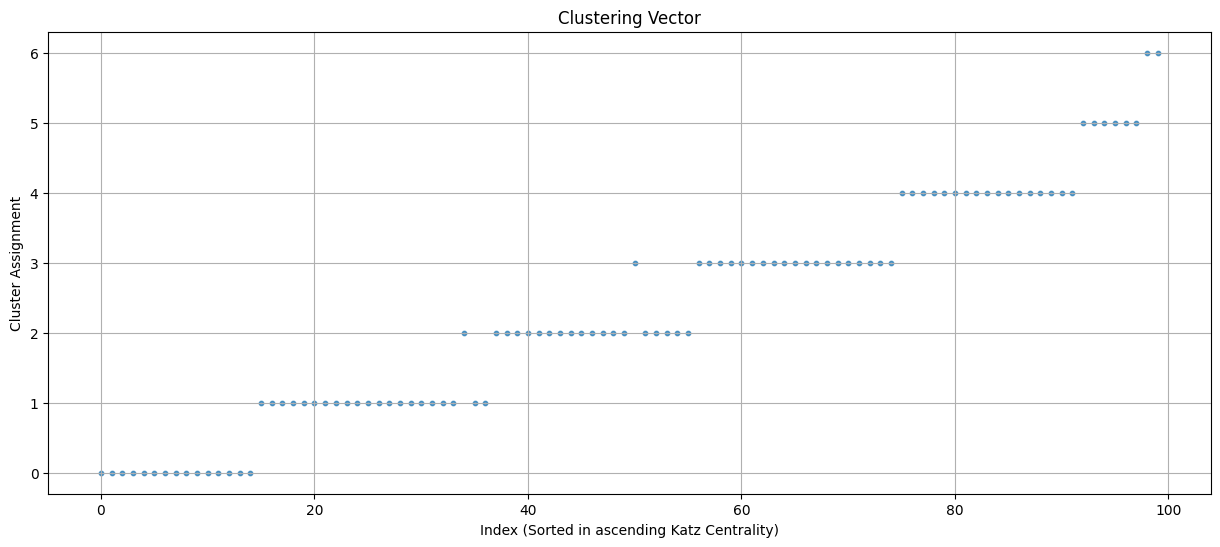

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def relabel_clusters(clustering_vector):
    relabeled_vector, _ = pd.factorize(clustering_vector)
    return relabeled_vector

# Creating a DataFrame for the clustering vector
data = pd.DataFrame({
    'Index': range(len(best_state_slow)),
    'Cluster': relabel_clusters(best_state_slow)
})

# Apply custom colors to the scatter plot
plt.figure(figsize=(15, 6))
plt.scatter(data['Index'], data['Cluster'], s=10, alpha=0.7)

plt.title('Clustering Vector')
plt.xlabel('Index (Sorted in ascending Katz Centrality)')
plt.ylabel('Cluster Assignment')
plt.grid(True)
#plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [8]:
import time
import numpy as np
from greedy_algo_fast import greedy_search

w = np.exp(-15)

# Measure the time taken by greedy_search
start_time = time.time()
best_state, best_clusters_objective = greedy_search(katz_vector, edges, np.array([0]*len(katz_vector)), w=w)
end_time = time.time()
greedy_search_time = end_time - start_time
print("Number of Clusters:", len(set(best_state)))

print("Fast greedy_search done!")
# Measure the time taken by greedy_algorithm_inefficient
start_time = time.time()
best_state_slow, best_clusters_objective_slow = greedy_algorithm_inefficient(katz_vector, adj_matrix.todense(), np.array([0]*len(katz_vector), dtype=np.int64), w=w)
end_time = time.time()
greedy_algorithm_inefficient_time = end_time - start_time

#assert np.allclose(best_clusters_objective, best_clusters_objective_slow)
#assert np.all(best_state == best_state_slow)
#print("Best state:", best_state)
print("Time taken by greedy_search: {:.6f} seconds".format(greedy_search_time))
print("Time taken by greedy_algorithm_inefficient: {:.6f} seconds".format(greedy_algorithm_inefficient_time))


Getting Initial Objective
Starting Iterating
Starting new iteration
Finished Iteration Init
Performing split moves
Found a better split at vertex best_split_index 57 of 100 for cluster 0 Best delta obj is now  -11.373573676158236
Iteration 0 Objective: 6.586138304606203
Starting new iteration
Finished Iteration Init
Performing split moves
Found a better split at vertex best_split_index 15 of 58 for cluster 1 Best delta obj is now  -1.886321308869371
Found a better split at vertex best_split_index 33 of 42 for cluster 0 Best delta obj is now  -2.5024220724347233
Iteration 1 Objective: 4.08371623217148
Starting new iteration
Finished Iteration Init
Performing split moves
Found a better split at vertex best_split_index 15 of 58 for cluster 1 Best delta obj is now  -1.886321308869371
Iteration 2 Objective: 2.197394923302109
Starting new iteration
Finished Iteration Init
Performing split moves
Found a better split at vertex best_split_index 1 of 16 for cluster 3 Best delta obj is now  -0.15

# Size stress test

In [9]:
import networkx as nx
import numpy as np
from variation_utils import calculate_katz
from scipy.sparse.linalg import eigs
import scipy.sparse as sp

def get_edge_vector_from_adj_matrix(adj_matrix):
    sparse_matrix = sp.csr_matrix(adj_matrix)
    row_indices, col_indices = sparse_matrix.nonzero()
    edge_vector = np.vstack((row_indices, col_indices)).T
    return edge_vector

def generate_adjacency_matrix_and_katz_vector(n, p, seed=42, alpha=0.1, beta=1.0):
    print("Getting G")
    G = nx.erdos_renyi_graph(n, p, directed=True, seed=seed)
    print("Got G")
    A_G = nx.adjacency_matrix(G).astype(np.float64)


    eigenvalues, _ = eigs(A_G, k=1, which='LM')  # 'LM': Largest Magnitude, tol is tolerance
    spectral_radius_G = np.abs(eigenvalues).max()
    print(f"Spectral Radius: {spectral_radius_G}, alpha_max = {1/spectral_radius_G}")
    print("calculating katz")
    katz_centrality = calculate_katz(A_G, alpha = alpha, beta=beta)
    print("done calculating katz")
    # Reorder nodes based on Katz centrality
    sorted_indices = np.argsort(katz_centrality)
    sorted_nodes = np.array(G.nodes())[sorted_indices]

    # Generate the adjacency matrix
    adj_matrix = nx.adjacency_matrix(G, nodelist=sorted_nodes)

    sorted_katz_vector = katz_centrality[sorted_indices]

    assert np.allclose(sorted_katz_vector, calculate_katz(adj_matrix.astype(np.float64), alpha = alpha, beta=beta))
    return adj_matrix, sorted_katz_vector


In [10]:
@njit
def generate_edge_indices(n, p, seed):
    np.random.seed(seed)
    row_indices = []
    col_indices = []

    # Expected number of edges
    E = int(n * (n * p))

    # Generate E unique edge indices
    edge_set = set()
    while len(edge_set) < E:
        i = np.random.randint(0, n)
        j = np.random.randint(0, n)
        edge_set.add((i, j))

    # Separate the set into row and column indices
    for edge in edge_set:
        row_indices.append(edge[0])
        col_indices.append(edge[1])

    return row_indices, col_indices


def generate_edge_list_and_katz_vector(n, p, seed=42, alpha=0.1, beta=1.0):
    row_indices, col_indices = generate_edge_indices(n, p, seed)
    print("Got Edge Indices")

    data = np.ones(len(row_indices))
    adj_matrix = sp.csr_matrix((data, (row_indices, col_indices)), shape=(n, n), dtype=np.float64)

    eigenvalues, _ = eigs(adj_matrix, k=1, which='LM')
    spectral_radius = np.abs(eigenvalues).max()
    print(f"Spectral Radius: {spectral_radius}, alpha_max = {1/spectral_radius}")

    katz_centrality = calculate_katz(adj_matrix, alpha=alpha, beta=beta)
    index_mapping =  np.argsort(np.argsort(katz_centrality))

    mapped_row_indices = index_mapping[row_indices]
    mapped_col_indices = index_mapping[col_indices]

    adj_matrix = sp.csr_matrix((data, (mapped_row_indices, mapped_col_indices)), shape=(n, n), dtype=np.float64)
    new_katz = calculate_katz(adj_matrix, alpha=alpha, beta=beta)
    assert np.allclose(np.sort(new_katz), new_katz)

    return adj_matrix, np.sort(new_katz)

In [11]:

n = 100_000
p = 4/n
adj_matrix, katz_vector = generate_edge_list_and_katz_vector(n=n, p=p, alpha=0.01)
edges = get_edge_vector_from_adj_matrix(adj_matrix)

Got Edge Indices
Spectral Radius: 3.9950913488028434, alpha_max = 0.2503071676445288
Katz converged after 11 iterations.
Katz converged after 11 iterations.


In [12]:
#%%prun -s cumtime
import time
import numpy as np

#w = 1.5*np.exp(-9) <- floating point issue that causes a point to be in one cluster
w = 1.5*np.exp(-10)

# Measure the time taken by greedy_search
start_time = time.time()
best_state, best_clusters_objective = greedy_search(katz_vector, edges, np.array([0]*len(katz_vector)), w=w)
end_time = time.time()
greedy_search_time = end_time - start_time

# numba is roughly factor 100 faster than native python for n=100_000 no_numba runs in 214s with @njit in 3s
print("Time taken by greedy_search: {:.6f} seconds".format(greedy_search_time))

Getting Initial Objective
Starting Iterating
Starting new iteration
Finished Iteration Init
Performing split moves
Found a better split at vertex best_split_index 62960 of 100000 for cluster 0 Best delta obj is now  -28.238412896550408
Iteration 0 Objective: 15.055333105860946
Starting new iteration
Finished Iteration Init
Performing split moves
Found a better split at vertex best_split_index 23755 of 62961 for cluster 1 Best delta obj is now  -6.183261118425505
Iteration 1 Objective: 8.87207198743544
Starting new iteration
Finished Iteration Init
Performing split moves
Found a better split at vertex best_split_index 9072 of 23756 for cluster 2 Best delta obj is now  -0.8803353472993745
Found a better split at vertex best_split_index 19486 of 39205 for cluster 1 Best delta obj is now  -1.0625541222670194
Found a better split at vertex best_split_index 26039 of 37039 for cluster 0 Best delta obj is now  -4.723104713913088
Iteration 2 Objective: 4.148967273522352
Starting new iteration
F

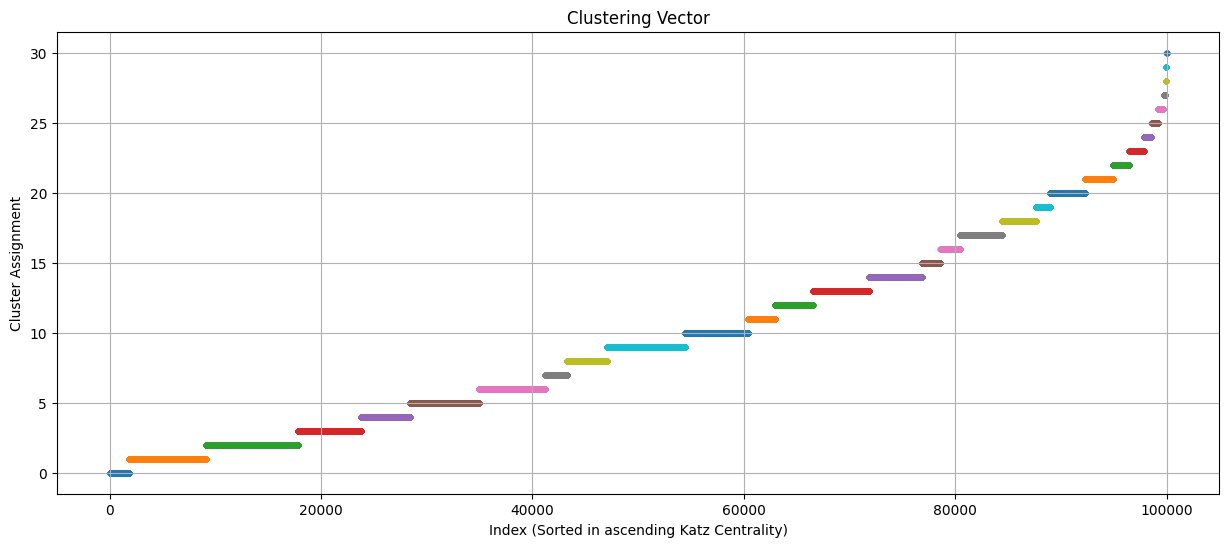

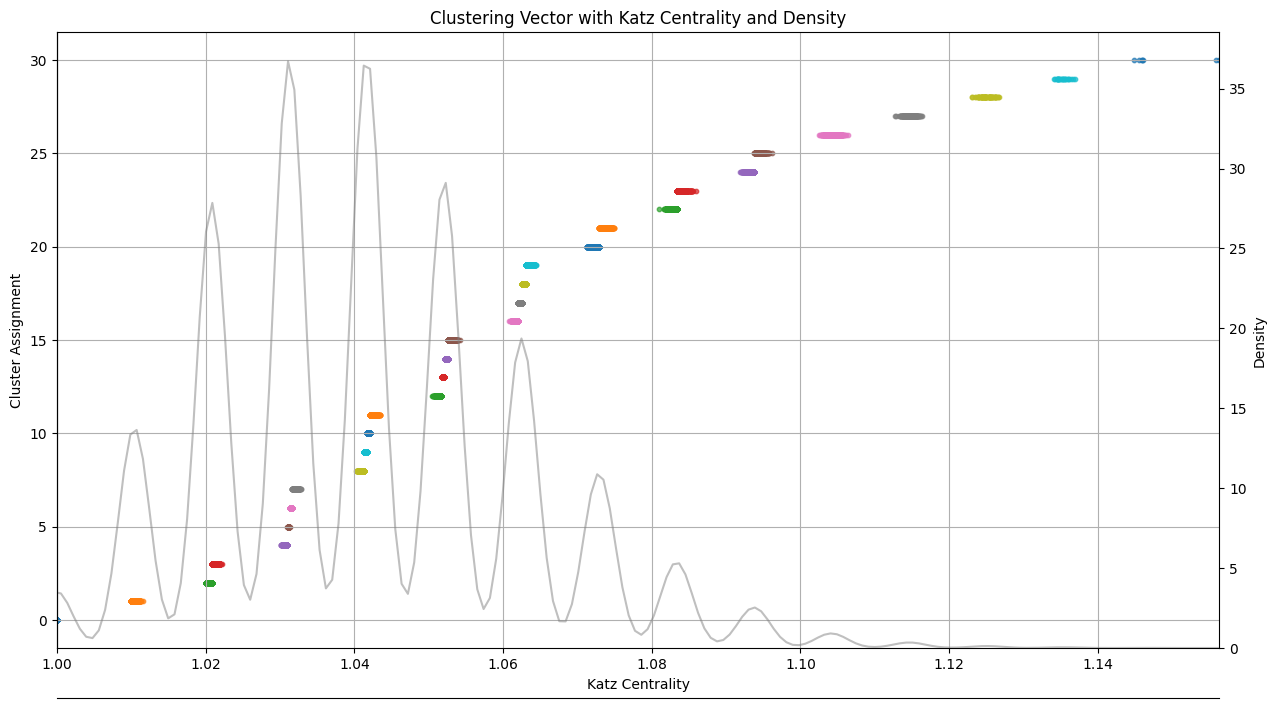

Unique Clusters: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Counts of each cluster: [1842 7231 8756 5927 4652 6565 6249 2021 3832 7350 5997 2539 3546 5368
 5006 1724 1848 3976 3223 1349 3251 2661 1572 1342  746  638  499  189
   69   25    7]
Minimum cluster size: 7


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def relabel_clusters(clustering_vector):
    relabeled_vector, _ = pd.factorize(clustering_vector)
    return relabeled_vector

# Define a function to create a custom color map for high contrast between consecutive clusters
def create_contrast_colormap(n_clusters, base_cmap='tab10'):
    # Basic contrasting colors
    cmap = plt.get_cmap(base_cmap)
    # Generate as many colors as needed by cycling through the colormap
    colors = [cmap(i % cmap.N) for i in range(n_clusters)]
    return colors

# Assume 'best_state' and 'katz_vector' are defined somewhere in your notebook
clusters = set(best_state)
num_clusters = len(clusters)  # Determine the number of unique clusters
custom_colors = create_contrast_colormap(num_clusters)

# Creating a DataFrame for the clustering vector
data = pd.DataFrame({
    'Index': range(len(best_state)),
    'Cluster': relabel_clusters(best_state)
})

# Apply custom colors to the scatter plot
plt.figure(figsize=(15, 6))
for i in clusters:
    cluster_data = data[data['Cluster'] == i]
    plt.scatter(cluster_data['Index'], cluster_data['Cluster'], color=custom_colors[i], s=10, alpha=0.7, label=f'Cluster {i}')

plt.title('Clustering Vector')
plt.xlabel('Index (Sorted in ascending Katz Centrality)')
plt.ylabel('Cluster Assignment')
plt.grid(True)
#plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Creating a DataFrame for the second plot
data = pd.DataFrame({
    'Katz_Centrality': katz_vector,
    'Cluster': relabel_clusters(best_state)
})

# Apply custom colors to the scatter plot
fig, ax1 = plt.subplots(figsize=(15, 8))
for i in range(num_clusters):
    cluster_data = data[data['Cluster'] == i]
    ax1.scatter(cluster_data['Katz_Centrality'], cluster_data['Cluster'], color=custom_colors[i], s=10, alpha=0.7, label=f'Cluster {i}')

ax1.set_xlabel('Katz Centrality')
ax1.set_ylabel('Cluster Assignment')
ax1.grid(True)
# Create a second axes for the KDE, sharing the same x-axis
ax2 = ax1.twinx()
sns.kdeplot(data['Katz_Centrality'], ax=ax2, color='gray', alpha=0.5)
ax2.set_ylabel('Density')
ax2.grid(False)

# Move the second axis to the bottom
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_position(('outward', 36))

# Adjust limits and appearance
ax2.set_ylim(0, None)
ax1.set_xlim(data['Katz_Centrality'].min(), data['Katz_Centrality'].max())

plt.title('Clustering Vector with Katz Centrality and Density')
plt.show()

# Use numpy.unique to find unique elements and their counts
unique_clusters, counts = np.unique(relabel_clusters(best_state), return_counts=True)
min_cluster_size = counts.min()
print("Unique Clusters:", unique_clusters)
print("Counts of each cluster:", counts)
print("Minimum cluster size:", min_cluster_size)

